In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
from functools import partial

START_DATE = '2017-01-01'
END_DATE = '2019-01-01'

In [22]:
def make_frame(content):
    prices = {}
    for line in content.split('\n'):
        if '{' in line or '}' in line:
            continue
        data = (
            line
            .lstrip().lstrip("'")
            .rstrip().rstrip("',")
            .split(':')
        )
        if len(data) < 3:
            data.append(np.nan)
        secs, price, volume = data
        prices[int(secs)] = (int(price), float(volume))
        
    price_frame = pd.DataFrame(prices, index = ['price', 'volume']).T
    price_frame.index = pd.to_datetime(price_frame.index, unit = 's')
    
    return price_frame

def fetch_from_wiki(item_name):
    # Totally lifted from:
    # https://github.com/osrsbox/osrsbox.github.io/blob/master/_posts/2018-12-14-scraping-the-osrs-wiki-part3.md
    
    # Construction custom user-agent for query
    custom_agent = {
        'User-Agent': 'CSCE421Scraper',
        'From': 'presley.graham@tamu.edu' 
    }
    
    page_title = f'Module:Exchange/{item_name}/Data'

    # Construct the para.meters of the API query
    parameters = {
        'action': 'parse',
        'prop': 'wikitext',
        'format': 'json',
        'page': page_title,
    }

    # Call the API using the custom user-agent and parameters
    result = requests.get('https://oldschool.runescape.wiki/api.php', 
                            headers=custom_agent, 
                            params=parameters).json()
    
    content = result['parse']['wikitext']['*']
    return make_frame(content)

In [23]:
def item_filename(item_name):
    return os.path.join('data', f'{item_name}.csv')

def fetch_from_disk(item_name):
    file_name = item_filename(item_name)
    
    # First, check to make sure the item is actually on disk
    if not os.path.isfile(file_name):
        return None
    
    # Read in the price frame; manually set index to first line
    price_frame = pd.read_csv(file_name).set_index('Unnamed: 0')
    
    display(price_frame)
    
    # Get rid of the ugly index name
    price_frame.index.name = None
    
    return price_frame

In [24]:
from functools import lru_cache

# fetch(item_name) returns 
@lru_cache(maxsize = None)
def fetch(item_name):
    # check if we have the item data on disk
    # TODO: check if the data is too old
    price_frame = None #fetch_from_disk(item_name)
    if price_frame is not None:
        return price_frame
    
    # if not, fetch it from the wiki
    price_frame = fetch_from_wiki(item_name)
    # and dump it to a file
    price_frame.to_csv(item_filename(item_name))
    return price_frame

In [25]:
# make mean 0
def demean(series):
    return series - series.mean()

def remove_outliers(series, sigma = 3):
    mean, std_dev = series.mean(), series.std()
    min_value = mean - sigma * std_dev
    max_value = mean + sigma * std_dev
    return series[(min_value <= series) & (series <= max_value)]

# half-open interval, like range()
def limit_to_dates(series, start_on = '1980-01-01', end_before = '2021-01-01'):
    start_date = pd.to_datetime(start_on)
    end_date = pd.to_datetime(end_before)
    return series[(start_date <= series.index) & (series.index < end_date)]

In [26]:
def prices(item_name):
    price = fetch(item_name)['price'].dropna()
    return price

def returns(item_name, lookback = 2):
    price = prices(item_name)
    return ((price - price.shift(lookback)) / price).dropna()

def gold_traded(item_name):
    prices = fetch(item_name)['price'] 
    volumes = fetch(item_name)['volume']
    return (prices * volumes).dropna()

In [27]:
def clean_returns(item_name, lookback = 4):
    raw_returns = returns(item_name, lookback)
    # set to zero mean and remove crazy outliers
    cleaned_returns = remove_outliers(demean(raw_returns), sigma = 4)
    # keep 2019 and beyond pristine
    cleaned_returns = limit_to_dates(cleaned_returns, start_on = START_DATE, end_before = END_DATE)
    return cleaned_returns

def oos_returns(item_name, lookback = 4):
    raw_returns = returns(item_name, lookback)
    # set to zero mean and remove crazy outliers
    cleaned_returns = remove_outliers(demean(raw_returns), sigma = 4)
    # use out of sample only
    cleaned_returns = limit_to_dates(cleaned_returns, start_on = END_DATE)
    return cleaned_returns


def clean_prices(item_name):
    raw_prices = prices(item_name)
    cleaned_prices = limit_to_dates(raw_prices, start_on = START_DATE, end_before = END_DATE)
    return cleaned_prices

def percent_prices(item_name):
    price = clean_prices(item_name)
    return price / price.mean()

In [28]:
def to_2d_array(df):
    if type(df) is pd.Series:
        return df.values.reshape(-1, 1)
    elif type(df) is pd.DataFrame:
        return df.values
    else:
        return df

def common_index(*series):
    common_index = series[0].index
    for serie in series[1:]:
        common_index &= serie.index
    return common_index

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, f1_score
from sklearn.svm import SVC # "Support vector classifier"

def get_svc_data(pred_names, resp_name, hold_period = 2, threshold = 0.03):
    if type(pred_names) is not list:
        pred_names = [pred_names]
    if resp_name not in pred_names:
        pred_names.append(resp_name)
    
    resp = (clean_returns(resp_name, lookback = hold_period).shift(-hold_period) > threshold).rename(resp_name)
    pred_list = [clean_returns(pred_name).rename(pred_name) for pred_name in pred_names]

    index = common_index(resp, *pred_list)
    
    pred = pd.concat(pred_list, axis = 1).reindex(index)
    resp = resp.reindex(index)
    
    X = to_2d_array(pred)
    y = to_2d_array(resp).reshape(-1)
    
    return X, y

def train_svc_model(pred_names, resp_name, threshold = 0.01):
    X, y = get_svc_data(pred_names, resp_name)
    
    model = SVC()
    model.fit(X, y)
    
    return model
    
def plot_svc_model(model, pred_names, resp_name, ax = None, plot_support = True):
    # source: https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
    
    X, y = get_svc_data(pred_names, resp_name)

    if ax is None:
        ax = plt.gca()
        
    xlim = (min(X[:, 0]) - 0.05, max(X[:, 0]) + 0.05)
    ylim = (min(X[:, 1]) - 0.05, max(X[:, 1]) + 0.05)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');

def evaluate_svc_model(model, pred_names, resp_name):
    X, y_true = get_svc_data(pred_names, resp_name)
    y_pred = model.predict(X)
    
    return f1_score(y_true, y_pred)
    
def beta(pred_names, resp_name, ax = None, func = clean_returns):
    if type(pred_names) is not list:
        pred_names = [pred_names]
    
    resp = func(resp_name).rename(resp_name)
    pred_list = [func(pred_name).rename(pred_name) for pred_name in pred_names]

    index = common_index(resp, *pred_list)
    
    pred = pd.concat(pred_list, axis = 1).reindex(index)
    resp = resp.reindex(index)
    
    X = to_2d_array(pred)
    y = to_2d_array(resp)
    
    model = LinearRegression(fit_intercept = True)
    model.fit(X, y)
    
    if ax is not None:
        assert len(pred_names) == 1, "can only make 2D plots with 1 predictor and 1 response"
        sns.regplot(pred, resp, ax = ax)
    
    betas = list(model.coef_[0])
    r2 = r2_score(y_true = y, y_pred = model.predict(X))
    if len(betas) == 1:
        betas = betas[0]
    return betas, r2


def plot_over_time(*item_names, func = clean_prices):
    frame = pd.concat([func(item_name).rename(item_name) for item_name in item_names], axis = 1)
    frame.plot()

In [30]:
def amount_to_trade(pred_name, resp_name, lookback, threshold, wrong_way = False, func = clean_returns):
    beta_, _ = beta(pred_name, resp_name, func = partial(clean_returns, lookback = lookback))
    
    actual_returns = func(resp_name, lookback = lookback)
    predicted_returns = beta_ * func(pred_name, lookback = lookback)
    
    index = common_index(actual_returns, predicted_returns)
    actual_returns = actual_returns.reindex(index)
    predicted_returns = predicted_returns.reindex(index)
    
    remaining_trade = (predicted_returns - actual_returns).reindex(index)
    
    remaining_trade[remaining_trade.abs() < threshold] = 0
    if not wrong_way:
        remaining_trade[(remaining_trade > 0) != (predicted_returns > 0)] = 0
    
    return remaining_trade

def score(item_name, trades, hold_time, func = clean_returns):
    true_profit = func(item_name, lookback = hold_time).shift(-hold_time)
    
    return trades * true_profit

def quick_eval(pred_name, resp_name, switch, total_time, threshold, func = clean_returns):
    trades = amount_to_trade(pred_name, resp_name, lookback = switch, threshold = threshold, func = func)
    scores = score(resp_name, trades, total_time - switch, func = func)
    display(scores[scores.abs() > 0])
    return scores.sum()

def test_eval(pred_name, resp_name, switch, total_time, threshold):
    return quick_eval(pred_name, resp_name, switch, total_time, threshold, oos_returns)

(0.9906905203633053, 0.9048434979695132)

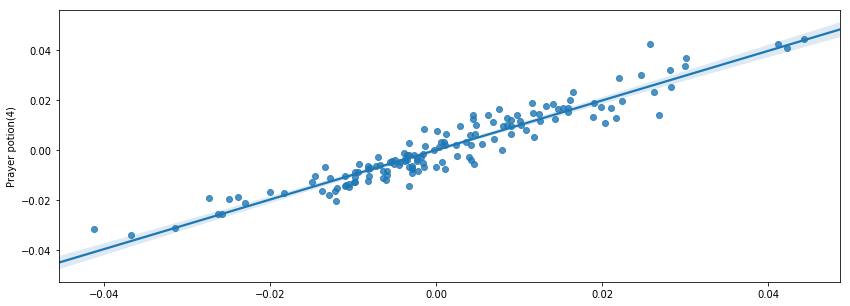

In [31]:
func_to_plot = lambda item_name : limit_to_dates(returns(item_name), '2018-08-01', '2019-01-01')
beta('Prayer potion(3)', 'Prayer potion(4)', func = func_to_plot, ax = plt.axes())

SHORT: beta: 0.338, r^2: 0.149
LONG:  beta: 0.551, r^2: 0.376


2017-01-09    6.700315e-04
2017-01-20    3.855301e-04
2017-01-21    1.434508e-03
2017-01-22    2.839307e-03
2017-02-01    3.042315e-04
2017-02-03   -5.141179e-07
2017-02-04    1.082909e-04
2017-02-05    1.665468e-04
2017-02-06    1.146773e-04
2017-02-09    7.750810e-05
2017-02-10    9.782865e-05
2017-02-19    1.349138e-03
2017-02-20    1.543918e-03
2017-02-21    6.221774e-04
2017-02-22   -8.431888e-04
2017-02-23    1.216247e-04
2017-02-24    1.863232e-03
2017-02-25    5.473742e-04
2017-02-27   -1.002525e-03
2017-02-28   -7.314709e-04
2017-03-01   -7.174814e-04
2017-03-04   -2.967215e-04
2017-03-05    1.612258e-04
2017-03-09    5.550924e-04
2017-03-10    3.900835e-04
2017-03-12    8.299094e-05
2017-03-13    1.362430e-03
2017-03-14    6.801814e-04
2017-03-15    3.342528e-04
2017-03-16   -3.359957e-04
                  ...     
2018-10-25    4.774233e-04
2018-10-26    5.505175e-04
2018-10-27    5.041699e-04
2018-11-01   -1.473188e-03
2018-11-02   -1.043765e-03
2018-11-04    1.499448e-03
2

in training: 0.017078427769175772


2019-01-04   -0.000464
2019-01-05    0.000386
2019-01-06    0.001745
2019-01-07    0.001327
2019-01-11   -0.002561
2019-01-12   -0.003746
2019-01-13    0.000417
2019-01-14    0.003810
2019-01-16   -0.000675
2019-01-17   -0.001593
2019-01-18   -0.001468
2019-01-19   -0.001427
2019-01-23   -0.000190
2019-01-24    0.000038
2019-01-26    0.000959
2019-01-28   -0.000235
2019-01-29    0.000425
2019-01-30    0.000283
2019-02-01   -0.000258
2019-02-02   -0.000210
2019-02-04    0.000340
2019-02-10    0.000305
2019-02-11    0.000891
2019-02-12    0.000947
2019-02-15   -0.000986
2019-02-20   -0.001068
2019-02-21   -0.001586
2019-02-22   -0.002064
2019-02-23   -0.001739
2019-02-25    0.000256
                ...   
2020-03-08    0.000332
2020-03-09    0.000707
2020-03-10    0.000471
2020-03-12   -0.000324
2020-03-13   -0.000334
2020-03-14   -0.000229
2020-03-18    0.000743
2020-03-19    0.001606
2020-03-20    0.001279
2020-03-21   -0.000490
2020-03-22   -0.000525
2020-03-23    0.000136
2020-03-26 

in testing:  0.12168898768196854
1.5413885458501237


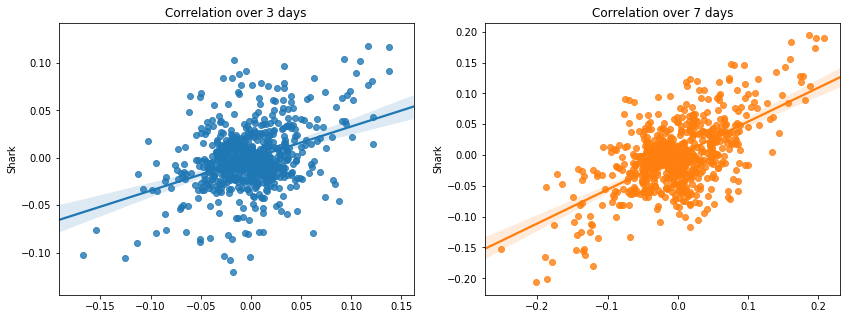

In [32]:
PRED = "Raw shark"
RESP = "Shark"
SHORT = 3
LONG = 7
THRESHOLD = 0.01

plt.rcParams["figure.figsize"] = (14, 5)

short_ax = plt.subplot(121) if type(PRED) is not list else None
long_ax = plt.subplot(122) if type(PRED) is not list else None

b, r = beta(PRED, RESP, func = partial(clean_returns, lookback = SHORT), ax = short_ax)
print(f"SHORT: beta: {b :.3f}, r^2: {r :.3f}")

b, r = beta(PRED, RESP, func = partial(clean_returns, lookback = LONG), ax = long_ax)
print(f"LONG:  beta: {b :.3f}, r^2: {r :.3f}")

if short_ax is not None:
    short_ax.set_title(f'Correlation over {SHORT} days')
    long_ax.set_title(f'Correlation over {LONG} days')

print('in training:', quick_eval(PRED, RESP, SHORT, LONG, THRESHOLD))
print('in testing: ', test_eval(PRED, RESP, SHORT, LONG, THRESHOLD))

print((1 + oos_returns('Raw shark')).prod())

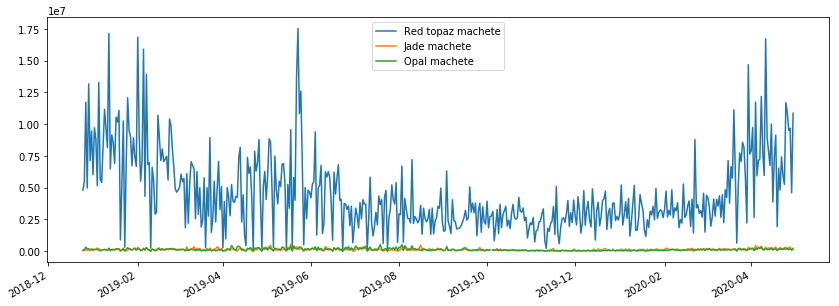

In [33]:
plot_over_time("Red topaz machete", "Jade machete", "Opal machete", func = gold_traded)

In [34]:
model = train_svc_model("Ranarr weed", "Prayer potion(4)")

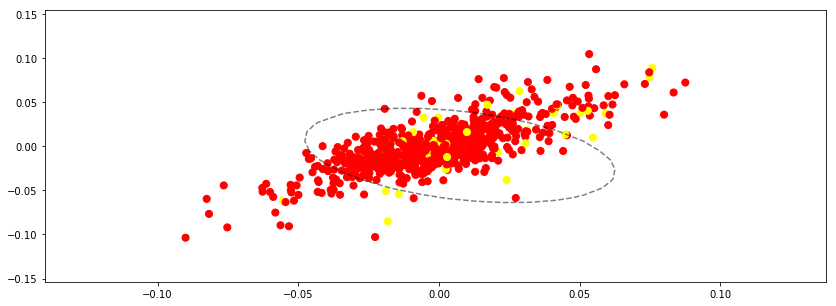

In [35]:
plot_svc_model(model, "Ranarr weed", "Prayer potion(4)")

In [37]:
#evaluate_svc_model(model, "Ranarr weed", "Prayer potion(4)")

(0.5302085192914114, 0.5014682688190052)

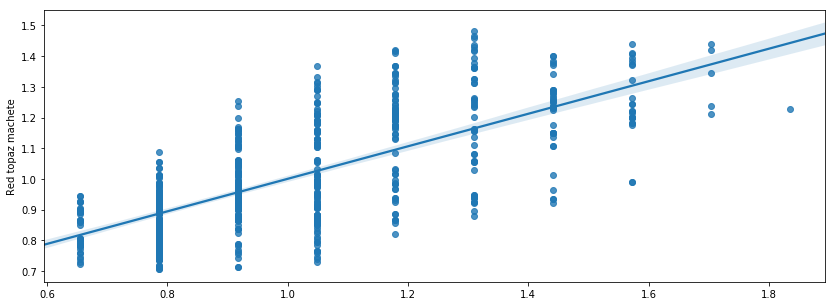

In [40]:
beta("Trading sticks", "Red topaz machete", func = partial(percent_prices), ax = plt.axes())

(0.0015537019238693207, 0.00012541373711161263)

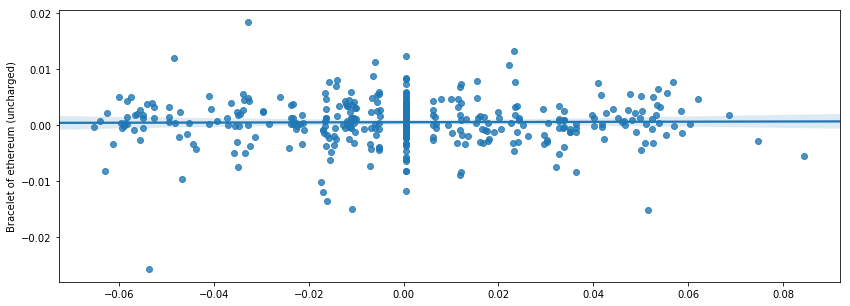

In [41]:
beta("Revenant ether", "Bracelet of ethereum (uncharged)", func = partial(clean_returns, lookback = 1), ax = plt.axes())

In [42]:
#SVM model implementation:

In [43]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

def double_plot(dList):
    fig, axs = plt.subplots(figsize=(15, 10))
    
    for (lst,label) in dList:
        axs.plot(lst.index,list(lst), label = label)
    
    fig.text(0.5, 0.04, 'date', ha='center', va='center')
    fig.text(0.06, 0.5, 'returns', ha='center', va='center', rotation='vertical')

    


    axs.legend()
    plt.show()

212
212
212


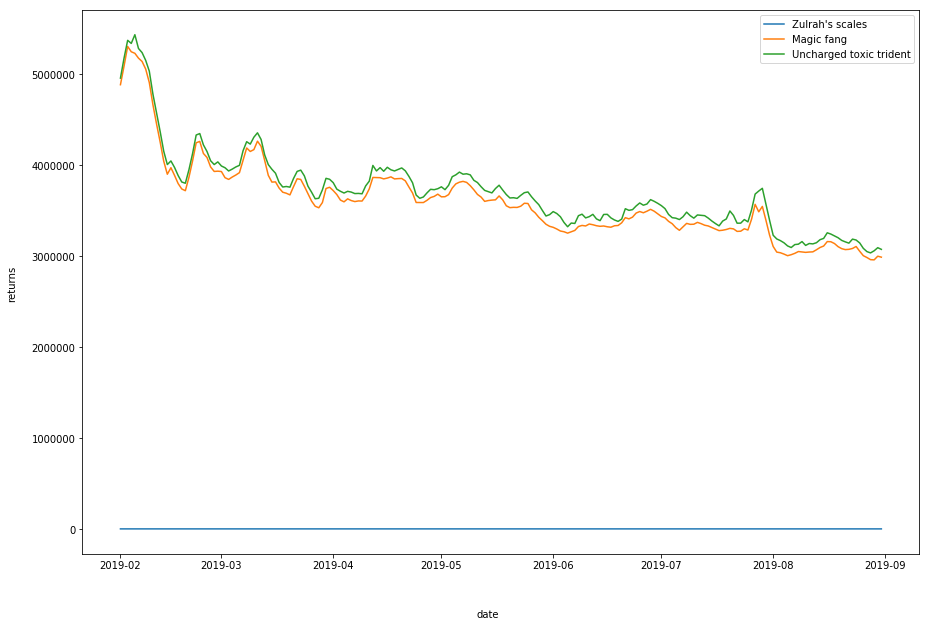

In [44]:
# half way point, any coorilation should be visible at this stage

itemList = []
itemList.append("Zulrah's scales")
itemList.append("Magic fang")
itemList.append("Uncharged toxic trident")


rItem = "Uncharged toxic trident"
shift = 3
train_test_split_ratio = 5

resultant = (limit_to_dates(prices(rItem), '2019-02-04', '2019-9-04'),rItem)
dList = []
for item in itemList:
    dList.append((limit_to_dates(prices(item), '2019-02-01', '2019-9-01'),item))
    print(len((limit_to_dates(prices(item), '2019-02-01', '2019-9-01'))))



double_plot(dList)





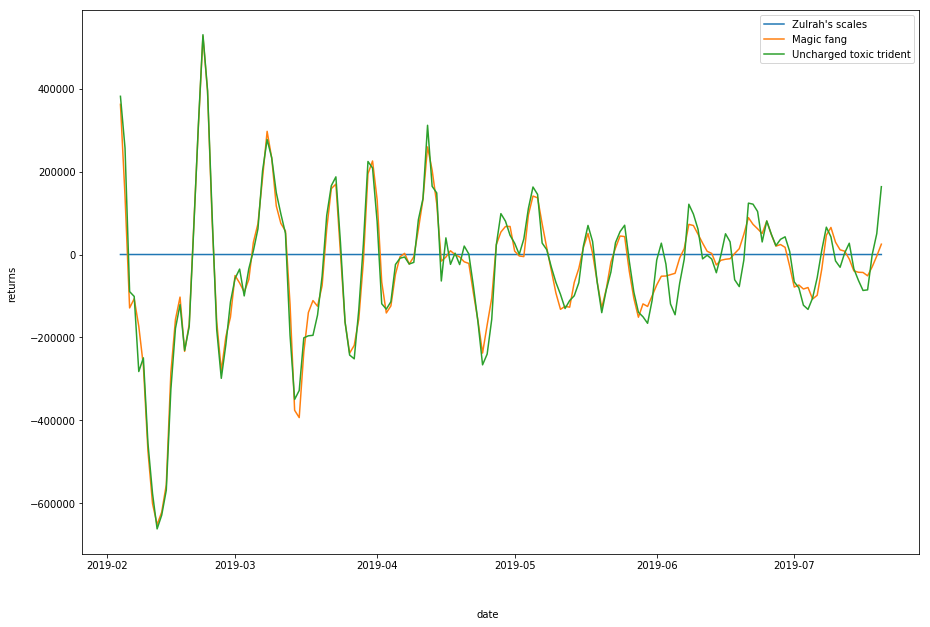

SVR(C=100000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-08,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [46]:
#calculating profit and creating labels based on them
from sklearn import svm

length = len(dList[0][0])

trainList = []
testList = []
for (data,label) in dList:
    trainList.append((data[:length-int(length/train_test_split_ratio)],label))
    testList.append((data[length-int(length/train_test_split_ratio):],label))
trainResultant = (resultant[0][:length-int(length/train_test_split_ratio)],resultant[1])
testResultant = (resultant[0][length-int(length/train_test_split_ratio):],resultant[1])


profitList = []
profitTest = []
for (data,label) in trainList:
    profitList.append(((data - data.shift(shift)).dropna(),label))
for (data,label) in testList:
    profitTest.append(((data - data.shift(shift)).dropna(),label))
profitResultant = ((trainResultant[0] - trainResultant[0].shift(shift)).dropna(),trainResultant[1])
testProfitResultant = ((testResultant[0] - testResultant[0].shift(shift)).dropna(),testResultant[1])
   
    
double_plot(profitList)


X = [[] for i in profitList[0][0]]
for (data,label) in profitList:
    for i in range(len(data)):
        X[i].append(data[i])
        
y = []
for val in profitResultant[0]:
    y.append(val)


clf = svm.SVR(C=100000,gamma = 1e-8)
clf.fit(X,y)





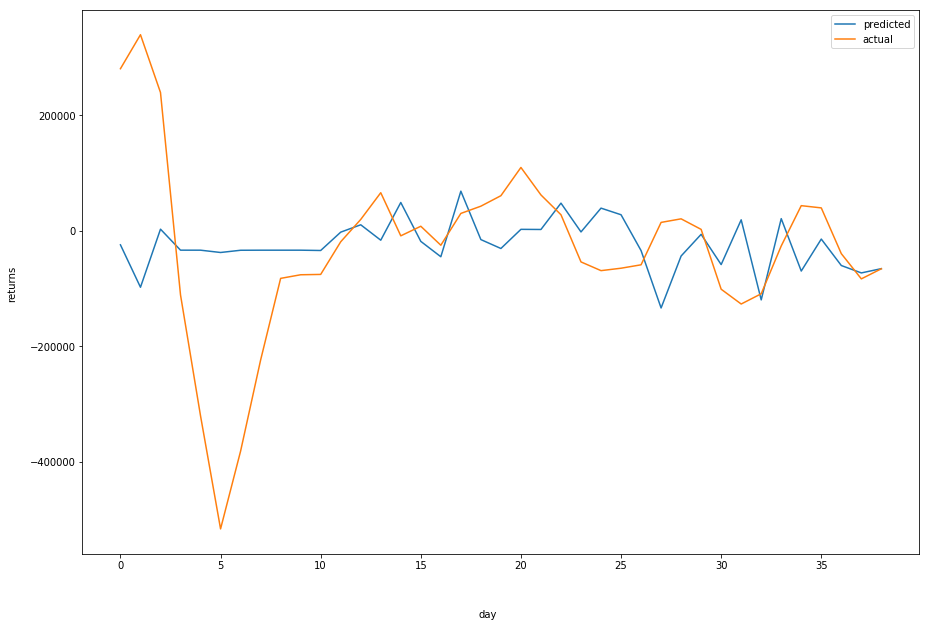

In [47]:
predictor = [[] for i in profitTest[0][0]]
for (data,label) in profitTest:
    for i in range(len(data)):
        predictor[i].append(data[i])

predicted = clf.predict(predictor)

fig, axs = plt.subplots(figsize=(15, 10))

x = range(len(predicted))

axs.plot(x,list(predicted), label = 'predicted')
axs.plot(x,list(testProfitResultant[0]), label = 'actual')
# axs.fill_between(x, testProfitResultant[0],predicted, where=abs(predicted-testProfitResultant[0]) <1000,
#                  facecolor='green', interpolate=True)
fig.text(0.5, 0.04, 'day', ha='center', va='center')
fig.text(0.06, 0.5, 'returns', ha='center', va='center', rotation='vertical')


axs.legend()
plt.show()